# Airline Data Cleaning

In this workbook, I explore every feature that comes from the airline dataset. I explore distributions and missing values and decide how to handle them. 

- [Data dictionary](https://docs.google.com/spreadsheets/d/1VKBW1Grj1eMToz9rRHRpO9RxljPsJ3Fs/edit#gid=1865636049)
- [Rationale for removing](https://docs.google.com/spreadsheets/d/1hj4W8B_U49jZOLH41LP1dL8OqRlD_-7m/edit#gid=764608588)

In [0]:
import pandas as pd
import numpy as np
from pyspark.sql import types, functions as F
from pyspark.sql.functions import col, max, row_number
from pyspark.sql.window import Window
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

Read in data

In [0]:
blob_container = "main-storage" # The name of your container created in https://portal.azure.com
storage_account = "team05w261" # The name of your Storage account created in https://portal.azure.com
secret_scope = "team05" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "team05-key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

# Configure blob storage account access key globally
spark.conf.set(
  f"fs.azure.account.key.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

In [0]:
# df = spark.read.parquet(f"{blob_url}/2015_q1_full_join_5")
# df = spark.read.parquet(f"{blob_url}/all_time_full_join_1")
df = spark.read.parquet(f"{blob_url}/all_time_full_join_2_weather_cleaned")

df_numrows = df.count()
print(f"number of rows: {df_numrows}")
print(f"number of columns: {len(df.columns)}")
#display(df)

number of rows: 31178801
number of columns: 423

Creating functions that can be used to systematically clean the airline features

In [0]:
def airline_field_cleaner(df, clean_null=True, remove_outliers=True):
    '''
    Cleans every single airport column. Deals w/ NULLs and outliers.
    Must pass in the final joined df because I use that column naming.
    See google doc for reasoning behind these: https://docs.google.com/spreadsheets/d/1hj4W8B_U49jZOLH41LP1dL8OqRlD_-7m/edit#gid=764608588
    '''
    
    if clean_null:
        
        # For some vars, impute values for nulls
        df = df.na.fill({
            'CANCELLATION_CODE_AIRLNS': 'missing', 
            'ARR_DELAY_NEW_AIRLNS': 0, 
            'ARR_DEL15_AIRLNS': 0, 
            'ARR_DELAY_AIRLNS': 0, 
            'ARR_DELAY_GROUP_AIRLNS': 0})
        
        # drop some obs
        df = df.filter(~F.col('DEP_DEL15_AIRLNS').isNull()).filter(~F.col('ARR_TIME_AIRLNS').isNull())
        
        # drop some columns
        df = df.drop(*['CARRIER_DELAY_AIRLNS', 'WEATHER_DELAY_AIRLNS', 'NAS_DELAY_AIRLNS', 'SECURITY_DELAY_AIRLNS', 'LATE_AIRCRAFT_DELAY_AIRLNS']) 
        
        # median imputation based on origin/dest flights
        grp_df = df.groupby('origin_airlns', 'dest_airlns').agg(F.expr('percentile_approx(ACTUAL_ELAPSED_TIME_AIRLNS, .5)').alias('impute_val'))
        df = df.join(grp_df, on=['origin_airlns', 'dest_airlns'], how='left')
        df = df.withColumn('ACTUAL_ELAPSED_TIME_AIRLNS', 
                           F.when(F.col('ACTUAL_ELAPSED_TIME_AIRLNS').isNull(), 
                                  F.col('impute_val'))\
                           .otherwise(F.col('ACTUAL_ELAPSED_TIME_AIRLNS')))\
                .drop('impute_val')
        
        # final na's to drop
        df = df.filter(~F.col('ACTUAL_ELAPSED_TIME_AIRLNS').isNull()).filter(~F.col('CRS_ELAPSED_TIME_AIRLNS').isNull())
        
    
    if remove_outliers:
        
        # removing extreme outliers
        df = df\
            .filter(F.col('CRS_ELAPSED_TIME_AIRLNS') != 813)\
            .filter(F.col('CRS_ELAPSED_TIME_AIRLNS') > 0)\
            .filter(F.col('ACTUAL_ELAPSED_TIME_AIRLNS') != 1604)\
            .filter(F.col('ARR_DELAY_AIRLNS') <= 2300)
        
        
        # work more on this
    
    return df


# my null data imputation function for numerics
def impute_null_numeric(df, vars_to_impute, origin_or_dest='origin', method='median'):
    '''
    Inputs:
    df: full flights dataset
    vars_to_impute: a list of variabe names to impute null values for. Only works for numeric variables for now
    origin_or_dest: choose either origin or dest airport. Then this will be the airport used in the groupby
    method: can be either median or mean
    
    Output:
    pyspark dataframe with nulls replaced
    '''
    
    if origin_or_dest == 'origin':
        columns_to_groupby = ['year_airlns', 'month_airlns', 'origin_airlns']
        
    else:
        columns_to_groupby = ['year_airlns', 'month_airlns', 'dest_airlns']
    
    for var in vars_to_impute:
        
        if method == 'mean':
            grp_df = df.groupby(columns_to_groupby).agg(F.mean(var).alias('impute_val')).show(10)
        
        else:
            grp_df = df.groupby(columns_to_groupby).agg(F.expr(f'percentile_approx({var}, .5)').alias('impute_val'))
        
        
        df = df.join(grp_df, on=columns_to_groupby, how='left')
        df = df.withColumn(var, F.when(F.col(var).isNull(), F.col('impute_val')).otherwise(F.col(var))).drop('impute_val')
        
    return df

In [0]:
%run ../dataclean_functions

In [0]:
%run ./Phase_3_michelle

Functions and global vars for data cleaning

In [0]:
# data clean
df = generate_columns(df)
#df = airline_field_cleaner(df)
df.cache()
df.count()
display(df)

ORIGIN_AIRLNS DEST_AIRLNS YEAR_AIRLNS QUARTER_AIRLNS MONTH_AIRLNS DAY_OF_MONTH_AIRLNS DAY_OF_WEEK_AIRLNS FL_DATE_AIRLNS DEP_TIME_AIRLNS DEP_TIME_BLK_AIRLNS CRS_DEP_TIME_AIRLNS CRS_ARR_TIME_AIRLNS CRS_ELAPSED_TIME_AIRLNS ARR_TIME_AIRLNS ARR_TIME_BLK_AIRLNS ACTUAL_ELAPSED_TIME_AIRLNS ORIGIN_CITY_NAME_AIRLNS ORIGIN_STATE_ABR_AIRLNS ORIGIN_STATE_FIPS_AIRLNS ORIGIN_STATE_NM_AIRLNS ORIGIN_WAC_AIRLNS DEST_CITY_NAME_AIRLNS DEST_STATE_ABR_AIRLNS DEST_STATE_FIPS_AIRLNS DEST_STATE_NM_AIRLNS DEST_WAC_AIRLNS OP_UNIQUE_CARRIER_AIRLNS FLIGHTS_AIRLNS DISTANCE_AIRLNS DISTANCE_GROUP_AIRLNS DIVERTED_AIRLNS CANCELLED_AIRLNS CANCELLATION_CODE_AIRLNS DEP_DELAY_AIRLNS DEP_DELAY_NEW_AIRLNS DEP_DELAY_GROUP_AIRLNS DEP_DEL15_AIRLNS ARR_DELAY_AIRLNS ARR_DELAY_NEW_AIRLNS ARR_DELAY_GROUP_AIRLNS ARR_DEL15_AIRLNS id_AIRLNS datetime_dep iata_OPNFLGHT tz_db_time_zone_OPNFLGHT utc_dep utc_dep_3hrs_prior utc_dep_3hrs_prior_rounded STATION_WTHR_origin SOURCE_WTHR_origin DATE_WTHR_origin LATITUDE_WTHR_origin LONGITUDE_WTHR_origin ELEVATION_WTHR_origin NAME_WTHR_origin REPORT_TYPE_WTHR_origin CALL_SIGN_WTHR_origin QUALITY_CONTROL_WTHR_origin iata_origin icao_origin station_origin tz_db_time_zone_origin DATE_WTHR_rounded_origin STATION_WTHR_dest SOURCE_WTHR_dest DATE_WTHR_dest LATITUDE_WTHR_dest LONGITUDE_WTHR_dest ELEVATION_WTHR_dest NAME_WTHR_dest REPORT_TYPE_WTHR_dest CALL_SIGN_WTHR_dest QUALITY_CONTROL_WTHR_dest iata_dest icao_dest station_dest tz_db_time_zone_dest DATE_WTHR_rounded_dest row_number WND_WTHR_direction_angle_origin WND_WTHR_direction_quality_code_origin WND_WTHR_type_code_origin WND_WTHR_speed_rate_origin WND_WTHR_speed_quality_code_origin CIG_WTHR_ceiling_height_dimension_origin CIG_WTHR_ceiling_quality_code_origin CIG_WTHR_ceiling_determination_code_origin CIG_WTHR_CAVOK_code_origin VIS_WTHR_distance_dimension_origin VIS_WTHR_distance_quality_code_origin VIS_WTHR_variability_code_origin VIS_WTHR_quality_variability_code_origin TMP_WTHR_air_temperature_origin TMP_WTHR_air_temperature_quality_code_origin DEW_WTHR_dew_point_temperature_origin DEW_WTHR_dew_point_quality_code_origin SLP_WTHR_sea_level_pressure_origin SLP_WTHR_sea_level_pressure_quality_code_origin GA1_WTHR_coverage_code_origin GA1_WTHR_coverage_quality_code_origin GA1_WTHR_base_height_dimension_origin GA1_WTHR_base_height_quality_code_origin GA1_WTHR_cloud_type_code_origin GA1_WTHR_cloud_type_quality_code_origin GF1_WTHR_total_coverage_code_origin GF1_WTHR_ total_opaque_coverage_code_origin GF1_WTHR_quality_total_coverage_code_origin GF1_WTHR_total_lowest_cloud_cover_code_origin GF1_WTHR_quality_total_lowest_cloud_cover_code_origin GF1_WTHR_low_cloud_genus_code_origin GF1_WTHR_quality_low_cloud_genus_code_origin GF1_WTHR_lowest_cloud_base_height_dimension_origin GF1_WTHR_lowest_cloud_base_height_quality_code_origin GF1_WTHR_mid_cloud_genus_code_origin GF1_WTHR_quality_mid_cloud_genus_code_origin GF1_WTHR_high_cloud_genus_code_origin GF1_WTHR_quality_high_cloud_genus_code_origin MA1_WTHR_altimeter_setting_rate_origin MA1_WTHR_altimeter_quality_code_origin MA1_WTHR_station_pressure_rate_origin MA1_WTHR_station_pressure_quality_code_origin AA1_WTHR_period_quantity_in_hours_origin AA1_WTHR_depth_dimension_origin AA1_WTHR_condition_code_origin AA1_WTHR_quality_code_origin AA2_WTHR_period_quantity_in_hours_origin AA2_WTHR_depth_dimension_origin AA2_WTHR_condition_code_origin AA2_WTHR_quality_code_origin AJ1_WTHR_dimension_origin AJ1_WTHR_condition_code_origin AJ1_WTHR_quality_code_origin AJ1_WTHR_equivalent_water_depth_dimension_origin AJ1_WTHR_equivalent_water_condition_code_origin AJ1_WTHR_equivalent_water_condition_quality_code_origin AL1_WTHR_period_quantity_origin AL1_WTHR_depth_dimension_origin AL1_WTHR_condition_code_origin AL1_WTHR_quality_code_origin AN1_WTHR_period_quantity_origin AN1_WTHR_depth_dimension_origin AN1_WTHR_condition_code_origin AN1_WTHR_quality_code_origin AO1_WTHR_period_quantity_in_minutes_origin AO1_WTHR_depth_dimension_origin AO1_WTHR_condition_code_origin AO1_

# Explore Distributions, Outliers, and Missing Values

In [0]:
# select airline fields
df_airlines = df.select([i for i in df.columns if i.endswith('_AIRLNS')])
display(df_airlines)

YEAR_AIRLNS QUARTER_AIRLNS MONTH_AIRLNS DAY_OF_MONTH_AIRLNS DAY_OF_WEEK_AIRLNS FL_DATE_AIRLNS DEP_TIME_AIRLNS DEP_TIME_BLK_AIRLNS CRS_DEP_TIME_AIRLNS CRS_ARR_TIME_AIRLNS CRS_ELAPSED_TIME_AIRLNS ARR_TIME_AIRLNS ARR_TIME_BLK_AIRLNS ACTUAL_ELAPSED_TIME_AIRLNS ORIGIN_AIRLNS ORIGIN_CITY_NAME_AIRLNS ORIGIN_STATE_ABR_AIRLNS ORIGIN_STATE_FIPS_AIRLNS ORIGIN_STATE_NM_AIRLNS ORIGIN_WAC_AIRLNS DEST_AIRLNS DEST_CITY_NAME_AIRLNS DEST_STATE_ABR_AIRLNS DEST_STATE_FIPS_AIRLNS DEST_STATE_NM_AIRLNS DEST_WAC_AIRLNS OP_UNIQUE_CARRIER_AIRLNS FLIGHTS_AIRLNS DISTANCE_AIRLNS DISTANCE_GROUP_AIRLNS CARRIER_DELAY_AIRLNS DEP_DELAY_AIRLNS DEP_DELAY_NEW_AIRLNS DEP_DELAY_GROUP_AIRLNS DEP_DEL15_AIRLNS ARR_DELAY_AIRLNS ARR_DELAY_NEW_AIRLNS ARR_DELAY_GROUP_AIRLNS ARR_DEL15_AIRLNS WEATHER_DELAY_AIRLNS NAS_DELAY_AIRLNS SECURITY_DELAY_AIRLNS LATE_AIRCRAFT_DELAY_AIRLNS TAIL_NUM_AIRLNS id_AIRLNS 2016 2 4 21 4 2016-04-21 1924 1900-1959 1921 2230 369.0 2213 2200-2259 349.0 EWR Newark, NJ NJ 34 New Jersey 21 SEA Seattle, WA WA 53 Washington 93 UA 1.0 2402.0 10 null 3.0 3.0 0 0.0 -17.0 0.0 -2 0.0 null null null null N78448 948 2016 2 4 1 5 2016-04-01 1742 1600-1659 1630 1900 150.0 2005 1900-1959 143.0 FLL Fort Lauderdale, FL FL 12 Florida 33 DCA Washington, DC VA 51 Virginia 38 WN 1.0 899.0 4 31.0 72.0 72.0 4 1.0 65.0 65.0 4 1.0 0.0 0.0 0.0 34.0 N713SW 1021 2016 2 4 28 4 2016-04-28 1855 1800-1859 1805 1853 108.0 1919 1800-1859 84.0 LAN Lansing, MI MI 26 Michigan 43 MSP Minneapolis, MN MN 27 Minnesota 63 EV 1.0 455.0 2 0.0 50.0 50.0 3 1.0 26.0 26.0 1 1.0 0.0 26.0 0.0 0.0 N371CA 1452 2019 1 3 30 6 2019-03-30 1458 1500-1559 1502 1657 235.0 1647 1600-1659 229.0 ORD Chicago, IL IL 17 Illinois 41 PHX Phoenix, AZ AZ 4 Arizona 81 NK 1.0 1440.0 6 null -4.0 0.0 -1 0.0 -10.0 0.0 -1 0.0 null null null null N683NK 1731 2019 1 3 2 6 2019-03-02 2117 2100-2159 2120 2216 56.0 2215 2200-2259 58.0 DFW Dallas/Fort Worth, TX TX 48 Texas 74 OKC Oklahoma City, OK OK 40 Oklahoma 73 AA 1.0 175.0 1 null -3.0 0.0 -1 0.0 -1.0 0.0 -1 0.0 null null null null N936AN 1805 2019 1 3 7 4 2019-03-07 1805 1800-1859 1810 1930 80.0 1914 1900-1959 69.0 IAH Houston, TX TX 48 Texas 74 JAN Jackson/Vicksburg, MS MS 28 Mississippi 53 EV 1.0 351.0 2 null -5.0 0.0 -1 0.0 -16.0 0.0 -2 0.0 null null null null N17560 2026 2019 1 3 14 4 2019-03-14 1107 0900-0959 930 1040 70.0 1219 1000-1059 72.0 SHV Shreveport, LA LA 22 Louisiana 72 IAH Houston, TX TX 48 Texas 74 EV 1.0 192.0 1 0.0 97.0 97.0 6 1.0 99.0 99.0 6 1.0 0.0 2.0 0.0 97.0 N15572 2043 2019 1 3 2 6 2019-03-02 641 0600-0659 650 900 190.0 845 0900-0959 184.0 MIA Miami, FL FL 12 Florida 33 AUS Austin, TX TX 48 Texas 74 AA 1.0 1103.0 5 null -9.0 0.0 -1 0.0 -15.0 0.0 -1 0.0 null null null null N940NN 2550 2019 1 3 19 2 2019-03-19 1314 1300-1359 1325 1414 49.0 1356 1400-1459 42.0 DEN Denver, CO CO 8 Colorado 82 PUB Pueblo, CO CO 8 Colorado 82 OO 1.0 109.0 1 null -11.0 0.0 -1 0.0 -18.0 0.0 -2 0.0 null null null null N961SW 2694 2019 1 1 8 2 2019-01-08 1428 1400-1459 1415 1610 235.0 1557 1600-1659 209.0 HOU Houston, TX TX 48 Texas 74 LAX Los Angeles, CA CA 6 California 91 WN 1.0 1390.0 6 null 13.0 13.0 0 0.0 -13.0 0.0 -1 0.0 null null null null N437WN 2999 2019 1 1 6 7 2019-01-06 1816 1800-1859 1819 2027 68.0 2036 2000-2059 80.0 ORD Chicago, IL IL 17 Illinois 41 DAY Dayton, OH OH 39 Ohio 44 OH 1.0 240.0 1 null -3.0 0.0 -1 0.0 9.0 9.0 0 0.0 null null null null N510AE 3036 2019 1 1 15 2 2019-01-15 1606 1600-1659 1610 2159 229.0 2142 2100-2159 216.0 PHX Phoenix, AZ AZ 4 Arizona 81 TPA Tampa, FL FL 12 Florida 33 AA 1.0 1788.0 8 null -4.0 0.0 -1 0.0 -17.0 0.0 -2 0.0 null null null null N660AW 3156 2019 1 1 31 4 2019-01-31 638 0600-0659 650 1100 370.0 1030 1100-1159 352.0 SAN San Diego, CA CA 6 California 91 KOA Kona, HI HI 15 Hawaii 2 AS 1.0 2556.0 11 null -12.0 0.0 -1 0.0 -30.0 0.0 -2 0.0 null null null null N588AS 3463 2019 1 1 31 4 2019-01-31 1150 1100-1159 1155 1440 165.0 1421 1400-1459 151.0 SEA Seattle, WA WA 53 Washington 93 SAN San Diego, CA CA 6 California 91 AS 1.0 1

Out[109]:

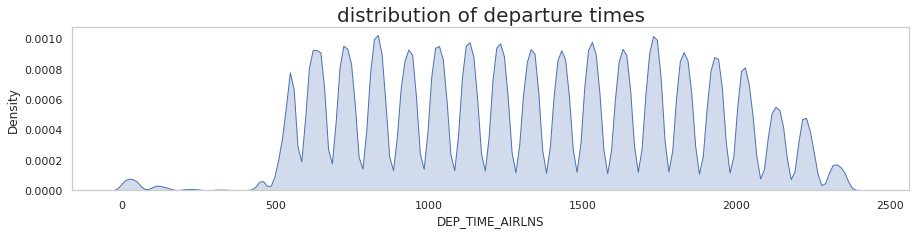

Text(0.5, 1.0, 'distribution of departure times')

In [0]:
sns.set(rc = {'figure.figsize':(15,3)})
sns.set_style("whitegrid", {'axes.grid' : False}) 

plot_df = df_airlines.select('DEP_TIME_AIRLNS').toPandas()

# the actual plot
sns.kdeplot(data=plot_df, x="DEP_TIME_AIRLNS", 
    bw_adjust=.8, 
    fill=True,
    log_scale=False
    )\
    .set_title("distribution of departure times", size=20)

/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(
Out[10]:

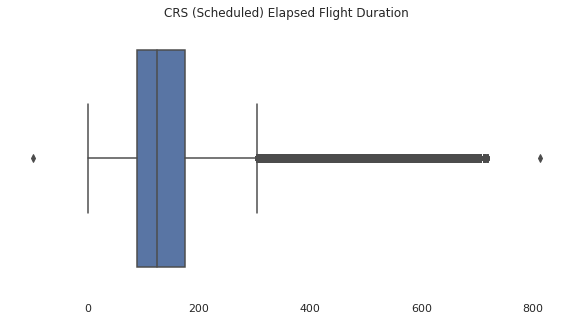

[Text(0.5, 1.0, 'CRS (Scheduled) Elapsed Flight Duration')]

In [0]:
var_i = 'CRS_ELAPSED_TIME_AIRLNS'

sns.set(rc={'figure.figsize':(10,5), 'figure.facecolor':'white', 'axes.facecolor':'white'})
plot_df = df_airlines.select(var_i).toPandas()
p = sns.boxplot(plot_df[var_i])
p.set_xlabel('')
p.set(title="CRS (Scheduled) Elapsed Flight Duration")

The scheduled flight duration has a negative value and an extremely high outlier. We may want to remove these.

/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(
Out[11]:

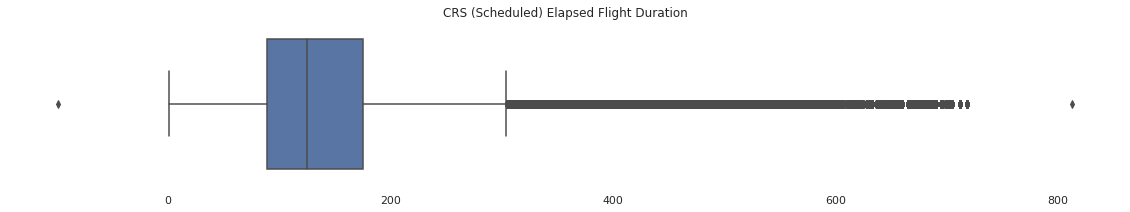

[Text(0.5, 1.0, 'CRS (Scheduled) Elapsed Flight Duration')]

In [0]:
var_i = 'CRS_ELAPSED_TIME_AIRLNS'

sns.set(rc={'figure.figsize':(20,3), 'figure.facecolor':'white', 'axes.facecolor':'white'})
plot_df = df_airlines.select(var_i).toPandas()
p = sns.boxplot(plot_df[var_i])
p.set_xlabel('')
p.set(title="CRS (Scheduled) Elapsed Flight Duration")

In [0]:
var_i = 'AA1_WTHR_depth_dimension_origin'
df.select(var_i).sort(var_i, ascending=False).show(10)

+-------------------------------+
AA1_WTHR_depth_dimension_origin|
+-------------------------------+
 254.0|
 253.7|
 253.7|
 253.7|
 252.9|
 252.4|
 251.9|
 251.7|
 238.8|
 233.9|
+-------------------------------+
only showing top 10 rows

/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(
Out[21]:

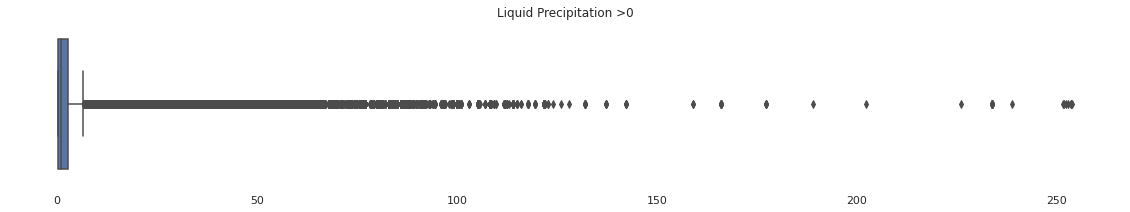

[Text(0.5, 1.0, 'Liquid Precipitation >0')]

In [0]:
var_i = 'AA1_WTHR_depth_dimension_origin'
# var_i = 'AA1_WTHR_depth_dimension_dest'
# var_i = 'AJ1_WTHR_equivalent_water_depth_dimension_origin'

sns.set(rc={'figure.figsize':(20,3), 'figure.facecolor':'white', 'axes.facecolor':'white'})
plot_df = df.select(var_i).filter(F.col(var_i)>0).toPandas()
p = sns.boxplot(plot_df[var_i])
p.set_xlabel('')
p.set(title="Liquid Precipitation >0")

Out[110]:

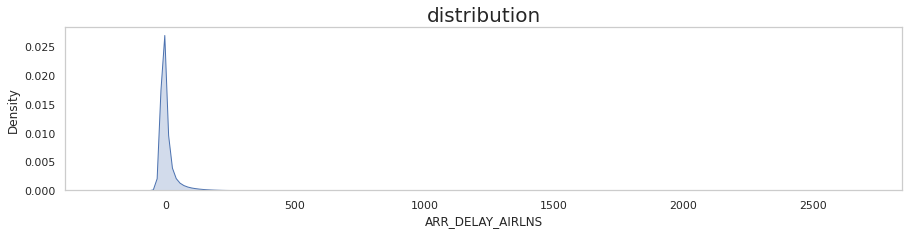

Text(0.5, 1.0, 'distribution')

In [0]:
sns.set(rc = {'figure.figsize':(15,3)})
sns.set_style("whitegrid", {'axes.grid' : False}) 

plot_df = df.select('ARR_DELAY_AIRLNS').toPandas()

# the actual plot
sns.kdeplot(data=plot_df, x="ARR_DELAY_AIRLNS", 
    bw_adjust=.8, 
    fill=True,
    log_scale=False
    )\
    .set_title("distribution", size=20)

Out[101]:

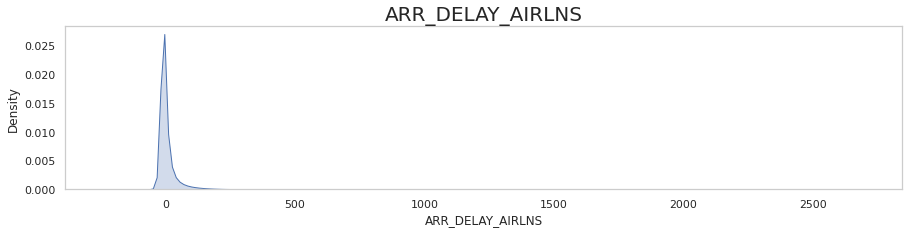

Text(0.5, 1.0, 'ARR_DELAY_AIRLNS')

In [0]:
sns.set(rc = {'figure.figsize':(15,3)})
sns.set_style("whitegrid", {'axes.grid' : False}) 
plot_df = df.select(['ACTUAL_ELAPSED_TIME_AIRLNS', 'ARR_DELAY_AIRLNS', 'ARR_DELAY_NEW_AIRLNS', 'ARR_DELAY_GROUP_AIRLNS', 'ARR_DEL15_AIRLNS']).toPandas()

sns.kdeplot(data=plot_df, x="ARR_DELAY_AIRLNS", 
    bw_adjust=.8, 
    fill=True,
    log_scale=False
    )\
    .set_title("ARR_DELAY_AIRLNS", size=20)

Out[97]:

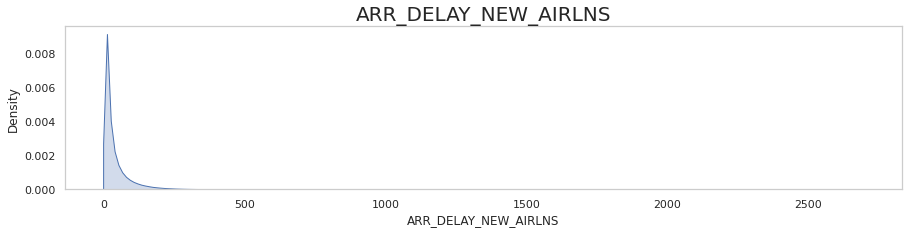

Text(0.5, 1.0, 'ARR_DELAY_NEW_AIRLNS')

In [0]:
sns.kdeplot(data=plot_df, x="ARR_DELAY_NEW_AIRLNS", 
    bw_adjust=.8, 
    fill=True,
    log_scale=False
    )\
    .set_title("ARR_DELAY_NEW_AIRLNS", size=20)

Out[100]:

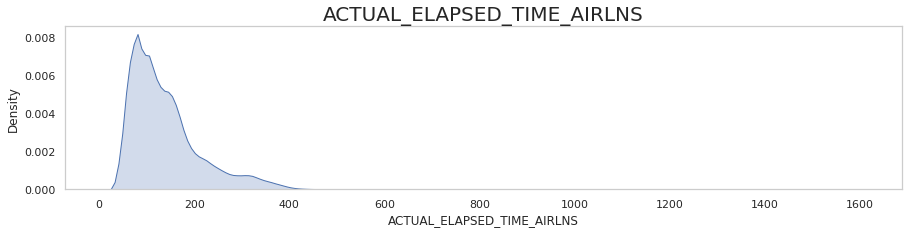

Text(0.5, 1.0, 'ACTUAL_ELAPSED_TIME_AIRLNS')

In [0]:
sns.kdeplot(data=plot_df, x="ACTUAL_ELAPSED_TIME_AIRLNS", 
    bw_adjust=.8, 
    fill=True,
    log_scale=False
    )\
    .set_title("ACTUAL_ELAPSED_TIME_AIRLNS", size=20)

Out[98]:

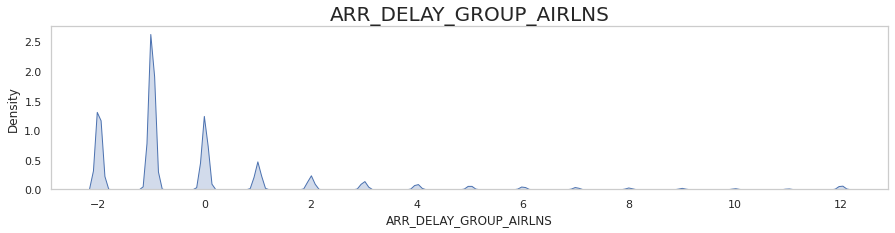

Text(0.5, 1.0, 'ARR_DELAY_GROUP_AIRLNS')

In [0]:
sns.kdeplot(data=plot_df, x="ARR_DELAY_GROUP_AIRLNS", 
    bw_adjust=.8, 
    fill=True,
    log_scale=False
    )\
    .set_title("ARR_DELAY_GROUP_AIRLNS", size=20)

In [0]:
df.groupby('ARR_DELAY_GROUP_AIRLNS').count().show()

+----------------------+--------+
ARR_DELAY_GROUP_AIRLNS| count|
+----------------------+--------+
 -1|12769984|
 12| 321066|
 null| 570632|
 1| 2149927|
 6| 236097|
 3| 659272|
 5| 318101|
 9| 109822|
 4| 444219|
 8| 139900|
 7| 180853|
 10| 86159|
 -2| 6843972|
 11| 68203|
 2| 1085496|
 0| 5763128|
+----------------------+--------+

Out[99]:

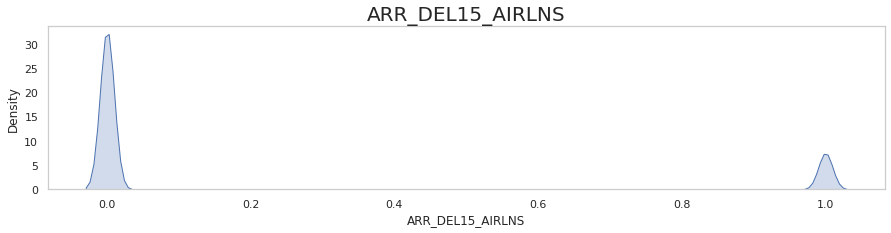

Text(0.5, 1.0, 'ARR_DEL15_AIRLNS')

In [0]:
sns.kdeplot(data=plot_df, x="ARR_DEL15_AIRLNS", 
    bw_adjust=.8, 
    fill=True,
    log_scale=False
    )\
    .set_title("ARR_DEL15_AIRLNS", size=20)

Out[11]:

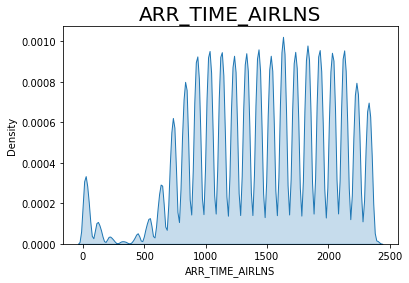

Text(0.5, 1.0, 'ARR_TIME_AIRLNS')

In [0]:
plot_df = df_airlines.select('ARR_TIME_AIRLNS').toPandas()

sns.kdeplot(data=plot_df, x="ARR_TIME_AIRLNS", 
    bw_adjust=.8, 
    fill=True,
    log_scale=False
    )\
    .set_title("ARR_TIME_AIRLNS", size=20)

In [0]:
grp_df = df.groupby('origin_airlns', 'dest_airlns').agg(F.expr('percentile_approx(ACTUAL_ELAPSED_TIME_AIRLNS, .5)').alias('impute_val'))
grp_df.show(10)


+-------------+-----------+----------+
origin_airlns|dest_airlns|impute_val|
+-------------+-----------+----------+
 ABE| BNA| 118.0|
 ABE| CLT| 124.0|
 ABE| FLL| 163.0|
 ABI| DFW| 54.0|
 ABQ| ORD| 165.0|
 ABQ| SAT| 100.0|
 ABY| ATL| 56.0|
 ACK| JFK| 62.0|
 ACY| FLL| 154.0|
 ACY| MCO| 141.0|
+-------------+-----------+----------+
only showing top 10 rows

In [0]:
# df = df.withColumnRenamed("GF1_WTHR_ total_opaque_coverage_code_origin", 'GF1_WTHR_total_opaque_coverage_code_origin')
# df = df.withColumnRenamed("GF1_WTHR_ total_opaque_coverage_code_dest", 'GF1_WTHR_total_opaque_coverage_code_dest')

# count nulls in airline columns
for i, var in enumerate(df_airlines.columns):
    if i == 0:
        missing_df = pd.DataFrame({"column": [], "num_null": []})
    else:
        #print(f'working on {var}')
        dfi = pd.DataFrame({"column": [var], "num_null": [df_airlines.select(f'{var}').filter(f'{var} is null').count()]})
        
        missing_df = pd.concat([
            missing_df, dfi
        ])

missing_df.sort_values('num_null')

Out[84]:

column 
 num_null 
 
 
 
 
 0 
 QUARTER_AIRLNS 
 0.0 
 
 
 0 
 DEST_CITY_NAME_AIRLNS 
 0.0 
 
 
 0 
 DEST_STATE_ABR_AIRLNS 
 0.0 
 
 
 0 
 DEST_STATE_NM_AIRLNS 
 0.0 
 
 
 0 
 DEST_WAC_AIRLNS 
 0.0 
 
 
 0 
 OP_UNIQUE_CARRIER_AIRLNS 
 0.0 
 
 
 0 
 FLIGHTS_AIRLNS 
 0.0 
 
 
 0 
 DEST_AIRLNS 
 0.0 
 
 
 0 
 DISTANCE_AIRLNS 
 0.0 
 
 
 0 
 DIVERTED_AIRLNS 
 0.0 
 
 
 0 
 CANCELLED_AIRLNS 
 0.0 
 
 
 0 
 DEP_DELAY_AIRLNS 
 0.0 
 
 
 0 
 DEP_DELAY_NEW_AIRLNS 
 0.0 
 
 
 0 
 DEP_DELAY_GROUP_AIRLNS 
 0.0 
 
 
 0 
 DEP_DEL15_AIRLNS 
 0.0 
 
 
 0 
 DISTANCE_GROUP_AIRLNS 
 0.0 
 
 
 0 
 ORIGIN_WAC_AIRLNS 
 0.0 
 
 
 0 
 DEST_STATE_FIPS_AIRLNS 
 0.0 
 
 
 0 
 ORIGIN_STATE_FIPS_AIRLNS 
 0.0 
 
 
 0 
 MONTH_AIRLNS 
 0.0 
 
 
 0 
 DAY_OF_MONTH_AIRLNS 
 0.0 
 
 
 0 
 DAY_OF_WEEK_AIRLNS 
 0.0 
 
 
 0 
 FL_DATE_AIRLNS 
 0.0 
 
 
 0 
 ORIGIN_STATE_NM_AIRLNS 
 0.0 
 
 
 0 
 DEP_TIME_AIRLNS 
 0.0 
 
 
 0 
 DEP_TIME_BLK_AIRLNS 
 0.0 
 
 
 0 
 CRS_DEP_TIME_AIRLNS 
 0.0 
 
 
 0 
 id_AIRLNS 
 0.0 
 
 
 0 
 ORIGIN_STATE_ABR_AIRLNS 
 0.0 
 
 
 0 
 CRS_ARR_TIME_AIRLNS 
 0.0 
 
 
 0 
 ARR_TIME_BLK_AIRLNS 
 0.0 
 
 
 0 
 ORIGIN_CITY_NAME_AIRLNS 
 0.0 
 
 
 0 
 ORIGIN_AIRLNS 
 0.0 
 
 
 0 
 CRS_ELAPSED_TIME_AIRLNS 
 31.0 
 
 
 0 
 ARR_TIME_AIRLNS 
 29363.0 
 
 
 0 
 ACTUAL_ELAPSED_TIME_AIRLNS 
 95471.0 
 
 
 0 
 ARR_DELAY_AIRLNS 
 97932.0 
 
 
 0 
 ARR_DELAY_NEW_AIRLNS 
 97932.0 
 
 
 0 
 ARR_DELAY_GROUP_AIRLNS 
 97932.0 
 
 
 0 
 ARR_DEL15_AIRLNS 
 97932.0 
 
 
 0 
 CARRIER_DELAY_AIRLNS 
 25470764.0 
 
 
 0 
 WEATHER_DELAY_AIRLNS 
 25470764.0 
 
 
 0 
 NAS_DELAY_AIRLNS 
 25470764.0 
 
 
 0 
 SECURITY_DELAY_AIRLNS 
 25470764.0 
 
 
 0 
 LATE_AIRCRAFT_DELAY_AIRLNS 
 25470764.0 
 
 
 0 
 CANCELLATION_CODE_AIRLNS 
 31252148.0

In [0]:
def airline_field_cleaner(df, clean_null=True, remove_outliers=True):
    '''
    Cleans every single airport column. Deals w/ NULLs and outliers.
    Must pass in the final joined df because I use that column naming.
    See google doc for reasoning behind these: https://docs.google.com/spreadsheets/d/1hj4W8B_U49jZOLH41LP1dL8OqRlD_-7m/edit#gid=764608588
    '''
    
    if clean_null:
        df = df.withColumn('CANCELLATION_CODE_AIRLNS', F.when(F.col('CANCELLATION_CODE_AIRLNS').isNull(), 'missing').otherwise(F.col('CANCELLATION_CODE_AIRLNS')))
        df = df.filter(~F.col('DEP_DEL15_AIRLNS').isNull())
        df = df.filter(~F.col('ARR_DELAY_AIRLNS').isNull())
        df = df.drop(['CARRIER_DELAY_AIRLNS', 'WEATHER_DELAY_AIRLNS', 'NAS_DELAY_AIRLNS', 'SECURITY_DELAY_AIRLNS', 'LATE_AIRCRAFT_DELAY_AIRLNS']) 
    
    if remove_outliers:
        pass
    
    return df

In [0]:
# clean every single airport column
# see google doc for reasoning behind these
# https://docs.google.com/spreadsheets/d/1hj4W8B_U49jZOLH41LP1dL8OqRlD_-7m/edit#gid=764608588

# CANCELLATION_CODE_AIRLNS is almost all missing (only <5k obs are not null), and looks like a response var to me. 
# just in case we want to dig in, i'll replace missing values w/ "missing"
df_airlines.withColumn('CANCELLATION_CODE_AIRLNS', F.when(F.col('CANCELLATION_CODE_AIRLNS').isNull(), 'missing').otherwise(F.col('CANCELLATION_CODE_AIRLNS')))

# DEP_DEL15_AIRLNS. 3% of obs are missing. This is our response var. Just removing these
df_airlines = df_airlines.filter(~F.col('DEP_DEL15_AIRLNS').isNull())

# Now these 5 vars are .3% missing:
# [ACTUAL_ELAPSED_TIME_AIRLNS, ARR_DELAY_AIRLNS, ARR_DELAY_NEW_AIRLNS, ARR_DELAY_GROUP_AIRLNS, ARR_DEL15_AIRLNS]
# these are all missing together: [ARR_DELAY_AIRLNS, ARR_DELAY_NEW_AIRLNS, ARR_DELAY_GROUP_AIRLNS, ARR_DEL15_AIRLNS]

# # ARR_TIME_AIRLNS


#
# such few obs, i say we remove them. 
df_airlines = df_airlines.filter(~F.col('ACTUAL_ELAPSED_TIME_AIRLNS').isNull())

# These 5 obs are 78% missing. They are also primarily response variables, and come as a result of an airline being delayed. 
# [CARRIER_DELAY_AIRLNS, WEATHER_DELAY_AIRLNS, NAS_DELAY_AIRLNS, SECURITY_DELAY_AIRLNS, LATE_AIRCRAFT_DELAY_AIRLNS]
# I'd like to just impute 0 or 'missing' for these. But they some missing values occur when there is no delay, or it'll say 0 when there is actually a delay.
# So these are just very incomplete. I'm deleting them.
df_airlines = df_airlines.drop(['CARRIER_DELAY_AIRLNS', 'WEATHER_DELAY_AIRLNS', 'NAS_DELAY_AIRLNS', 'SECURITY_DELAY_AIRLNS', 'LATE_AIRCRAFT_DELAY_AIRLNS']) 

In [0]:
#df_airlines = df_airlines.filter(~F.col('ACTUAL_ELAPSED_TIME_AIRLNS').isNull())

# count nulls in airline columns
for i, var in enumerate(df_airlines.columns):
    if i == 0:
        missing_df = pd.DataFrame({"column": [], "num_null": []})
    else:
        #print(f'working on {var}')
        dfi = pd.DataFrame({"column": [var], "num_null": [df_airlines.select(f'{var}').filter(f'{var} is null').count()]})
        
        missing_df = pd.concat([
            missing_df, dfi
        ])

missing_df.loc[missing_df.num_null >0, :].sort_values('num_null')

Out[39]:

column 
 num_null 
 
 
 
 
 0 
 CARRIER_DELAY_AIRLNS 
 120777.0 
 
 
 0 
 WEATHER_DELAY_AIRLNS 
 120777.0 
 
 
 0 
 NAS_DELAY_AIRLNS 
 120777.0 
 
 
 0 
 SECURITY_DELAY_AIRLNS 
 120777.0 
 
 
 0 
 LATE_AIRCRAFT_DELAY_AIRLNS 
 120777.0

Re-running from the source table to make sure these data cleaning steps work

In [0]:
# make sure my null remover function works
df = spark.read.parquet(f"{blob_url}/all_time_full_join_1")
df = generate_columns(df)
df = airline_field_cleaner(df)
df_airlines = df.select([i for i in df.columns if i.endswith('_AIRLNS')])
df_airlines.cache()



for i, var in enumerate(df_airlines.columns):
    if i == 0:
        missing_df = pd.DataFrame({"column": [], "num_null": []})
    else:
        #print(f'working on {var}')
        dfi = pd.DataFrame({"column": [var], "num_null": [df_airlines.select(var).filter(F.col(var).isNull()).count()]})
        
        missing_df = pd.concat([
            missing_df, dfi
        ])

missing_df.loc[missing_df.num_null >0, :].sort_values('num_null')

Out[7]:

column 
 num_null

Everything is not null!

In [0]:
missing_df

Out[8]:

column 
 num_null 
 
 
 
 
 0 
 DEST_AIRLNS 
 0.0 
 
 
 0 
 YEAR_AIRLNS 
 0.0 
 
 
 0 
 QUARTER_AIRLNS 
 0.0 
 
 
 0 
 MONTH_AIRLNS 
 0.0 
 
 
 0 
 DAY_OF_MONTH_AIRLNS 
 0.0 
 
 
 0 
 DAY_OF_WEEK_AIRLNS 
 0.0 
 
 
 0 
 FL_DATE_AIRLNS 
 0.0 
 
 
 0 
 DEP_TIME_AIRLNS 
 0.0 
 
 
 0 
 DEP_TIME_BLK_AIRLNS 
 0.0 
 
 
 0 
 CRS_DEP_TIME_AIRLNS 
 0.0 
 
 
 0 
 CRS_ARR_TIME_AIRLNS 
 0.0 
 
 
 0 
 ARR_TIME_AIRLNS 
 0.0 
 
 
 0 
 ARR_TIME_BLK_AIRLNS 
 0.0 
 
 
 0 
 ORIGIN_CITY_NAME_AIRLNS 
 0.0 
 
 
 0 
 ORIGIN_STATE_ABR_AIRLNS 
 0.0 
 
 
 0 
 ORIGIN_STATE_FIPS_AIRLNS 
 0.0 
 
 
 0 
 ORIGIN_STATE_NM_AIRLNS 
 0.0 
 
 
 0 
 ORIGIN_WAC_AIRLNS 
 0.0 
 
 
 0 
 DEST_CITY_NAME_AIRLNS 
 0.0 
 
 
 0 
 DEST_STATE_ABR_AIRLNS 
 0.0 
 
 
 0 
 DEST_STATE_FIPS_AIRLNS 
 0.0 
 
 
 0 
 DEST_STATE_NM_AIRLNS 
 0.0 
 
 
 0 
 DEST_WAC_AIRLNS 
 0.0 
 
 
 0 
 OP_UNIQUE_CARRIER_AIRLNS 
 0.0 
 
 
 0 
 FLIGHTS_AIRLNS 
 0.0 
 
 
 0 
 DISTANCE_AIRLNS 
 0.0 
 
 
 0 
 DISTANCE_GROUP_AIRLNS 
 0.0 
 
 
 0 
 DIVERTED_AIRLNS 
 0.0 
 
 
 0 
 CANCELLED_AIRLNS 
 0.0 
 
 
 0 
 CANCELLATION_CODE_AIRLNS 
 0.0 
 
 
 0 
 DEP_DELAY_AIRLNS 
 0.0 
 
 
 0 
 DEP_DELAY_NEW_AIRLNS 
 0.0 
 
 
 0 
 DEP_DELAY_GROUP_AIRLNS 
 0.0 
 
 
 0 
 DEP_DEL15_AIRLNS 
 0.0 
 
 
 0 
 ARR_DELAY_AIRLNS 
 0.0 
 
 
 0 
 ARR_DELAY_NEW_AIRLNS 
 0.0 
 
 
 0 
 ARR_DELAY_GROUP_AIRLNS 
 0.0 
 
 
 0 
 ARR_DEL15_AIRLNS 
 0.0 
 
 
 0 
 id_AIRLNS 
 0.0

---

<br><br><br>


# Outlier Decisions

In [0]:
df = spark.read.parquet(f"{blob_url}/all_time_full_join_1")
#df = generate_columns(df)
df = airline_field_cleaner(df)
df_airlines = df.select([i for i in df.columns if i.endswith('_AIRLNS')])
df_airlines.cache()
print(df_airlines.count())
display(df_airlines)

31240158

ORIGIN_AIRLNS DEST_AIRLNS YEAR_AIRLNS QUARTER_AIRLNS MONTH_AIRLNS DAY_OF_MONTH_AIRLNS DAY_OF_WEEK_AIRLNS FL_DATE_AIRLNS DEP_TIME_AIRLNS DEP_TIME_BLK_AIRLNS CRS_DEP_TIME_AIRLNS CRS_ARR_TIME_AIRLNS CRS_ELAPSED_TIME_AIRLNS ARR_TIME_AIRLNS ARR_TIME_BLK_AIRLNS ACTUAL_ELAPSED_TIME_AIRLNS ORIGIN_CITY_NAME_AIRLNS ORIGIN_STATE_ABR_AIRLNS ORIGIN_STATE_FIPS_AIRLNS ORIGIN_STATE_NM_AIRLNS ORIGIN_WAC_AIRLNS DEST_CITY_NAME_AIRLNS DEST_STATE_ABR_AIRLNS DEST_STATE_FIPS_AIRLNS DEST_STATE_NM_AIRLNS DEST_WAC_AIRLNS OP_UNIQUE_CARRIER_AIRLNS FLIGHTS_AIRLNS DISTANCE_AIRLNS DISTANCE_GROUP_AIRLNS DIVERTED_AIRLNS CANCELLED_AIRLNS CANCELLATION_CODE_AIRLNS DEP_DELAY_AIRLNS DEP_DELAY_NEW_AIRLNS DEP_DELAY_GROUP_AIRLNS DEP_DEL15_AIRLNS ARR_DELAY_AIRLNS ARR_DELAY_NEW_AIRLNS ARR_DELAY_GROUP_AIRLNS ARR_DEL15_AIRLNS id_AIRLNS ATL GSP 2015 4 10 16 5 2015-10-16 2309 2300-2359 2310 5 55.0 2351 0001-0559 42.0 Atlanta, GA GA 13 Georgia 34 Greer, SC SC 45 South Carolina 37 DL 1.0 153.0 1 0.0 0.0 missing -1.0 0.0 -1 0.0 -14.0 0.0 -1 0.0 146898 ATL GSP 2019 4 12 17 2 2019-12-17 1143 1100-1159 1130 1235 65.0 1241 1200-1259 58.0 Atlanta, GA GA 13 Georgia 34 Greer, SC SC 45 South Carolina 37 WN 1.0 153.0 1 0.0 0.0 missing 13.0 13.0 0 0.0 6.0 6.0 0 0.0 42949699649 ATL GSP 2017 2 6 12 1 2017-06-12 2131 2100-2159 2135 2237 62.0 2221 2200-2259 50.0 Atlanta, GA GA 13 Georgia 34 Greer, SC SC 45 South Carolina 37 DL 1.0 153.0 1 0.0 0.0 missing -4.0 0.0 -1 0.0 -16.0 0.0 -2 0.0 42949733819 ATL GSP 2016 3 9 22 4 2016-09-22 1009 1000-1059 1015 1115 60.0 1053 1100-1159 44.0 Atlanta, GA GA 13 Georgia 34 Greer, SC SC 45 South Carolina 37 WN 1.0 153.0 1 0.0 0.0 missing -6.0 0.0 -1 0.0 -22.0 0.0 -2 0.0 68719633996 ATL GSP 2015 4 11 8 7 2015-11-08 2105 2100-2159 2106 2209 63.0 2153 2200-2259 48.0 Atlanta, GA GA 13 Georgia 34 Greer, SC SC 45 South Carolina 37 DL 1.0 153.0 1 0.0 0.0 missing -1.0 0.0 -1 0.0 -16.0 0.0 -2 0.0 137439110164 ATL GSP 2017 3 9 23 6 2017-09-23 2220 2200-2259 2225 2317 52.0 2307 2300-2359 47.0 Atlanta, GA GA 13 Georgia 34 Greer, SC SC 45 South Carolina 37 DL 1.0 153.0 1 0.0 0.0 missing -5.0 0.0 -1 0.0 -10.0 0.0 -1 0.0 146029042894 ATL GSP 2018 3 7 29 7 2018-07-29 1920 1900-1959 1911 2013 62.0 2007 2000-2059 47.0 Atlanta, GA GA 13 Georgia 34 Greer, SC SC 45 South Carolina 37 DL 1.0 153.0 1 0.0 0.0 missing 9.0 9.0 0 0.0 -6.0 0.0 -1 0.0 163208832673 ATL GSP 2019 3 8 19 1 2019-08-19 1 2300-2359 2349 46 57.0 40 0001-0559 39.0 Atlanta, GA GA 13 Georgia 34 Greer, SC SC 45 South Carolina 37 DL 1.0 153.0 1 0.0 0.0 missing 12.0 12.0 0 0.0 -6.0 0.0 -1 0.0 171798716299 ATL GSP 2017 1 1 23 1 2017-01-23 1928 1900-1959 1900 1953 53.0 2016 1900-1959 48.0 Atlanta, GA GA 13 Georgia 34 Greer, SC SC 45 South Carolina 37 DL 1.0 153.0 1 0.0 0.0 missing 28.0 28.0 1 1.0 23.0 23.0 1 1.0 171798769034 ATL GSP 2015 3 7 5 7 2015-07-05 1903 1900-1959 1905 2005 60.0 1957 2000-2059 54.0 Atlanta, GA GA 13 Georgia 34 Greer, SC SC 45 South Carolina 37 DL 1.0 153.0 1 0.0 0.0 missing -2.0 0.0 -1 0.0 -8.0 0.0 -1 0.0 240518270648 ATL GSP 2019 1 2 7 4 2019-02-07 1056 1000-1059 1054 1150 56.0 1155 1100-1159 59.0 Atlanta, GA GA 13 Georgia 34 Greer, SC SC 45 South Carolina 37 DL 1.0 153.0 1 0.0 0.0 missing 2.0 2.0 0 0.0 5.0 5.0 0 0.0 249108197758 ATL GSP 2017 3 8 15 2 2017-08-15 1834 1700-1759 1740 1846 66.0 1921 1800-1859 47.0 Atlanta, GA GA 13 Georgia 34 Greer, SC SC 45 South Carolina 37 EV 1.0 153.0 1 0.0 0.0 missing 54.0 54.0 3 1.0 35.0 35.0 2 1.0 249108234067 ATL GSP 2019 4 10 18 5 2019-10-18 1801 1700-1759 1747 1842 55.0 1847 1800-1859 46.0 Atlanta, GA GA 13 Georgia 34 Greer, SC SC 45 South Carolina 37 DL 1.0 153.0 1 0.0 0.0 missing 14.0 14.0 0 0.0 5.0 5.0 0 0.0 257698080682 ATL GSP 2018 3 8 4 6 2018-08-04 1314 1300-1359 1319 1415 56.0 1359 1400-1459 45.0 Atlanta, GA GA 13 Georgia 34 Greer, SC SC 45 South Carolina 37 9E 1.0 153.0 1 0.0 0.0 missing -5.0 0.0 -1 0.0 -16.0 0.0 -2 0.0 257698138984 ATL GSP 2018 4 11 20 2 2018-11-20 2303 2200-2259 2250 2345 55.0 2359 2300-2359 56.0 Atlanta, GA GA 13 Georgia 34

In [0]:
df_airlines.registerTempTable("df_airlines")


In [0]:
df_airlines.groupby('ORIGIN_AIRLNS').count().show()

+-------------+-------+
ORIGIN_AIRLNS| count|
+-------------+-------+
 LWB| 1193|
 EUG| 20533|
 MYR| 39881|
 FAR| 24504|
 LEX| 35469|
 SAV| 55330|
 CAK| 30865|
 CVG| 151195|
 BUF| 102876|
 HPN| 42255|
 AUS| 271361|
 SRQ| 24583|
 CHS| 88905|
 BOS| 649432|
 EWR| 605545|
 DEN|1137667|
 SBA| 31609|
 CLT| 788831|
 MIA| 384597|
 SMF| 223589|
+-------------+-------+
only showing top 20 rows

In [0]:
# first i sanity checked the time vars by sorting to make sure all the values are normal

# cat vars do some group bys to see small values

vars_to_groupby = ['ORIGIN_AIRLNS', 'ORIGIN_CITY_NAME_AIRLNS', 'ORIGIN_STATE_ABR_AIRLNS', 'DEST_AIRLNS', 'DEST_STATE_NM_AIRLNS', 'DEST_CITY_NAME_AIRLNS', 
                  'OP_UNIQUE_CARRIER_AIRLNS']

for var in vars_to_groupby:
    df_airlines.groupby(var).count().sort('count').show()



+-------------+-----+
ORIGIN_AIRLNS|count|
+-------------+-----+
 EFD| 1|
 YNG| 2|
 ILG| 95|
 BFM| 151|
 FLO| 167|
 CEC| 174|
 XWA| 204|
 OWB| 208|
 OGD| 229|
 ART| 233|
 BKG| 290|
 AKN| 312|
 HGR| 318|
 STC| 352|
 IFP| 364|
 GST| 403|
 DLG| 407|
 UST| 414|
 HYA| 466|
 ADK| 496|
+-------------+-----+
only showing top 20 rows

+-----------------------+-----+
ORIGIN_CITY_NAME_AIRLNS|count|
+-----------------------+-----+
 Youngstown/Warren...| 2|
 Wilmington, DE| 95|
 Florence, SC| 167|
 Crescent City, CA| 174|
 Owensboro, KY| 208|
 Ogden, UT| 229|
 Watertown, NY| 233|
 Branson, MO| 290|
 King Salmon, AK| 312|
 Hagerstown, MD| 318|
 St. Cloud, MN| 352|
 Bullhead City, AZ| 364|
 Gustavus, AK| 403|
 Dillingham, AK| 407|
 St. Augustine, FL| 414|
 Hyannis, MA| 466|
 Adak Island, AK| 496|
 Watertown, SD| 497|
 Cheyenne, WY| 539|
 Pago Pago, TT| 596|
+-----------------------+-----+
only showing top 20 rows

+-----------------------+------+
ORIGIN_STATE_ABR_AIRLNS| count|
+-----------------------+------+
 DE| 95|
 TT| 3857|
 WV| 20344|
 VI| 24820|
 VT| 28968|
 NH| 37402|
 WY| 41228|
 ME| 48734|
 SD| 50683|
 KS| 60976|
 MS| 63984|
 RI| 73674|
 ND| 74401|
 MT| 92001|
 IA| 99982|
 ID|112808|
 AR|113618|
 CT|119790|
 NM|120798|
 NE|124438|
+-----------------------+------+
only showing top 20 rows

+-----------+-----+
DEST_AIRLNS|count|
+-----------+-----+
 FNL| 1|
 YNG| 2|
 ILG| 95|
 BFM| 154|
 FLO| 168|
 CEC| 177|
 XWA| 207|
 OWB| 208|
 OGD| 229|
 ART| 235|
 BKG| 292|
 AKN| 313|
 HGR| 320|
 STC| 351|
 IFP| 364|
 GST| 403|
 DLG| 408|
 UST| 418|
 HYA| 467|
 ATY| 493|
+-----------+-----+
only showing top 20 rows

+--------------------+------+
DEST_STATE_NM_AIRLNS| count|
+--------------------+------+
 Delaware| 95|
U.S. Pacific Trus...| 3860|
 West Virginia| 20368|
 U.S. Virgin Islands| 24872|
 Vermont| 29157|
 New Hampshire| 37426|
 Wyoming| 41262|
 Maine| 48914|
 South Dakota| 50754|
 Kansas| 61109|
 Mississippi| 64042|
 Rhode Island| 73845|
 North Dakota| 74501|
 Montana| 92060|
 Iowa|100088|
 Idaho|112376|
 Arkansas|113756|
 Connecticut|119947|
 New Mexico|120946|
 Nebraska|124594|
+--------------------+------+
only showing top 20 rows

+---------------------+-----+
DEST_CITY_NAME_AIRLNS|count|
+---------------------+-----+
 Fort Collins/Love...| 1|
 Youngstown/Warren...| 2|
 Wilmington, DE| 95|
 Florence, SC| 168|
 Crescent City, CA| 177|
 Owensboro, KY| 208|
 Ogden, UT| 229|
 Watertown, NY| 235|
 Branson, MO| 292|
 King Salmon, AK| 313|
 Hagerstown, MD| 320|
 St. Cloud, MN| 351|
 Bullhead City, AZ| 364|
 Gustavus, AK| 403|
 Dillingham, AK| 408|
 St. Augustine, FL| 418|
 Hyannis, MA| 467|
 Watertown, SD| 493|
 Adak Island, AK| 496|
 Cheyenne, WY| 540|
+---------------------+-----+
only showing top 20 rows

+------------------------+-------+
OP_UNIQUE_CARRIER_AIRLNS| count|
+------------------------+-------+
 US| 194586|
 G4| 200072|
 VX| 216984|
 HA| 399891|
 YV| 430719|
 9E| 487572|
 F9| 537087|
 OH| 548815|
 YX| 627336|
 NK| 778162|
 MQ| 880126|
 AS|1036153|
 B6|1423541|
 EV|1690485|
 UA|2863583|
 OO|3451223|
 AA|4330419|
 DL|4640738|
 WN|6502666|
+------------------------+-------+

/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(
/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 warnings.warn(

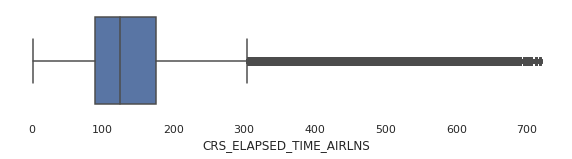

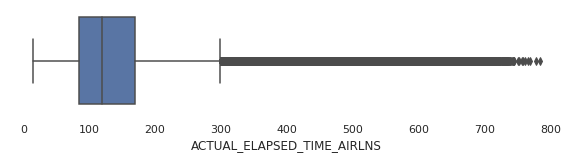

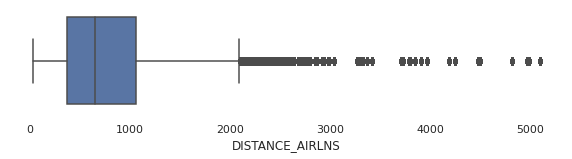

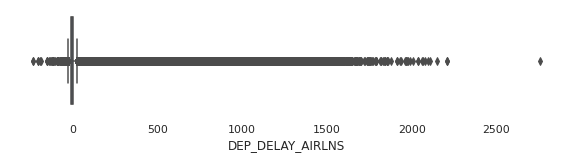

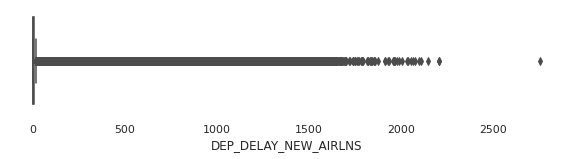

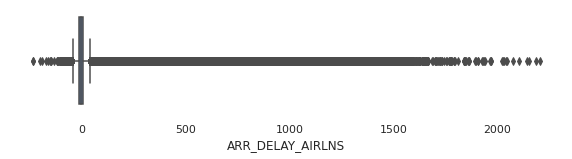

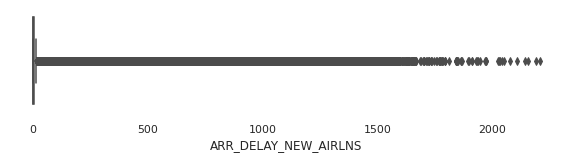

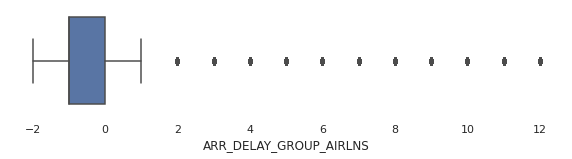

In [0]:
# make boxplots for exploration
# should probably not worry much about the delay variables b/c we won't know them in the test data. 
boxplot_vars = ['CRS_ELAPSED_TIME_AIRLNS', 'ACTUAL_ELAPSED_TIME_AIRLNS', 'DISTANCE_AIRLNS', 'DEP_DELAY_AIRLNS', 
                'DEP_DELAY_NEW_AIRLNS', 'ARR_DELAY_AIRLNS', 'ARR_DELAY_NEW_AIRLNS', 'ARR_DELAY_GROUP_AIRLNS']


# try on a small sample first maybe
df_airlines_pd = df_airlines.select(boxplot_vars).toPandas()

sns.set(rc={'figure.figsize':(10,2), 'figure.facecolor':'white', 'axes.facecolor':'white'})

for i, var in enumerate(boxplot_vars):
    plt.figure(i)
    sns.boxplot(df_airlines_pd[var])



print("")

In [0]:
display(df_airlines.sort('ARR_DELAY_AIRLNS', ascending=False))

ORIGIN_AIRLNS DEST_AIRLNS YEAR_AIRLNS QUARTER_AIRLNS MONTH_AIRLNS DAY_OF_MONTH_AIRLNS DAY_OF_WEEK_AIRLNS FL_DATE_AIRLNS DEP_TIME_AIRLNS DEP_TIME_BLK_AIRLNS CRS_DEP_TIME_AIRLNS CRS_ARR_TIME_AIRLNS CRS_ELAPSED_TIME_AIRLNS ARR_TIME_AIRLNS ARR_TIME_BLK_AIRLNS ACTUAL_ELAPSED_TIME_AIRLNS ORIGIN_CITY_NAME_AIRLNS ORIGIN_STATE_ABR_AIRLNS ORIGIN_STATE_FIPS_AIRLNS ORIGIN_STATE_NM_AIRLNS ORIGIN_WAC_AIRLNS DEST_CITY_NAME_AIRLNS DEST_STATE_ABR_AIRLNS DEST_STATE_FIPS_AIRLNS DEST_STATE_NM_AIRLNS DEST_WAC_AIRLNS OP_UNIQUE_CARRIER_AIRLNS FLIGHTS_AIRLNS DISTANCE_AIRLNS DISTANCE_GROUP_AIRLNS DIVERTED_AIRLNS CANCELLED_AIRLNS CANCELLATION_CODE_AIRLNS DEP_DELAY_AIRLNS DEP_DELAY_NEW_AIRLNS DEP_DELAY_GROUP_AIRLNS DEP_DEL15_AIRLNS ARR_DELAY_AIRLNS ARR_DELAY_NEW_AIRLNS ARR_DELAY_GROUP_AIRLNS ARR_DEL15_AIRLNS id_AIRLNS SYR ORD 2019 4 12 12 4 2019-12-12 1221 1500-1559 1511 1632 141.0 1327 1600-1659 126.0 Syracuse, NY NY 36 New York 22 Chicago, IL IL 17 Illinois 41 OO 1.0 607.0 3 0.0 0.0 missing 2710.0 2710.0 12 1.0 2695.0 2695.0 12 1.0 1142461335431 CLT JFK 2018 3 7 5 4 2018-07-05 833 1100-1159 1123 1329 126.0 1021 1300-1359 108.0 Charlotte, NC NC 37 North Carolina 36 New York, NY NY 36 New York 22 OO 1.0 541.0 3 0.0 0.0 missing 2710.0 2710.0 12 1.0 2692.0 2692.0 12 1.0 1142461402288 DTW LGA 2019 1 2 17 7 2019-02-17 1400 1700-1759 1728 1922 114.0 1531 1900-1959 91.0 Detroit, MI MI 26 Michigan 43 New York, NY NY 36 New York 22 MQ 1.0 502.0 3 0.0 0.0 missing 2672.0 2672.0 12 1.0 2649.0 2649.0 12 1.0 618475399223 HNL PPG 2018 1 2 9 5 2018-02-09 1002 1600-1659 1640 2130 350.0 1445 2100-2159 343.0 Honolulu, HI HI 15 Hawaii 2 Pago Pago, TT TT 75 U.S. Pacific Trust Territories and Possessions 5 HA 1.0 2599.0 11 0.0 0.0 missing 2482.0 2482.0 12 1.0 2475.0 2475.0 12 1.0 1580548086802 PPG HNL 2018 1 2 9 5 2018-02-09 1638 2300-2359 2330 600 330.0 2254 0600-0659 316.0 Pago Pago, TT TT 75 U.S. Pacific Trust Territories and Possessions 5 Honolulu, HI HI 15 Hawaii 2 HA 1.0 2599.0 11 0.0 0.0 missing 2468.0 2468.0 12 1.0 2454.0 2454.0 12 1.0 317827718233 OGG PHX 2019 3 7 24 3 2019-07-24 1155 2100-2159 2120 606 346.0 2116 0600-0659 381.0 Kahului, HI HI 15 Hawaii 2 Phoenix, AZ AZ 4 Arizona 81 AA 1.0 2845.0 11 0.0 0.0 missing 2315.0 2315.0 12 1.0 2350.0 2350.0 12 1.0 1460288880921 SBP PHX 2019 1 2 8 5 2019-02-08 1904 0600-0659 615 851 96.0 2137 0800-0859 93.0 San Luis Obispo, CA CA 6 California 91 Phoenix, AZ AZ 4 Arizona 81 YV 1.0 509.0 3 0.0 0.0 missing 2209.0 2209.0 12 1.0 2206.0 2206.0 12 1.0 1400159447020 HNL LAX 2017 4 12 25 1 2017-12-25 123 1200-1259 1235 2013 338.0 842 2000-2059 319.0 Honolulu, HI HI 15 Hawaii 2 Los Angeles, CA CA 6 California 91 AA 1.0 2556.0 11 0.0 0.0 missing 2208.0 2208.0 12 1.0 2189.0 2189.0 12 1.0 584115702940 BDL PHL 2018 4 10 21 7 2018-10-21 1912 0800-0859 803 920 77.0 2113 0900-0959 121.0 Hartford, CT CT 9 Connecticut 11 Philadelphia, PA PA 42 Pennsylvania 23 AA 1.0 196.0 1 0.0 0.0 missing 2109.0 2109.0 12 1.0 2153.0 2153.0 12 1.0 1700807131202 SFO DFW 2016 4 10 20 4 2016-10-20 1949 0800-0859 800 1333 213.0 115 1300-1359 206.0 San Francisco, CA CA 6 California 91 Dallas/Fort Worth, TX TX 48 Texas 74 AA 1.0 1464.0 6 0.0 0.0 missing 2149.0 2149.0 12 1.0 2142.0 2142.0 12 1.0 618475395833 TRI ATL 2018 4 12 9 7 2018-12-09 2 1300-1359 1304 1420 76.0 128 1400-1459 86.0 Bristol/Johnson City/Kingsport, TN TN 47 Tennessee 54 Atlanta, GA GA 13 Georgia 34 OO 1.0 227.0 1 0.0 0.0 missing 2098.0 2098.0 12 1.0 2108.0 2108.0 12 1.0 1408749308305 FAR ORD 2019 2 4 12 5 2019-04-12 1619 0001-0559 540 739 119.0 1814 0700-0759 115.0 Fargo, ND ND 38 North Dakota 66 Chicago, IL IL 17 Illinois 41 MQ 1.0 557.0 3 0.0 0.0 missing 2079.0 2079.0 12 1.0 2075.0 2075.0 12 1.0 781684091405 SUX ORD 2019 1 2 7 4 2019-02-07 1615 0001-0559 551 734 103.0 1744 0700-0759 89.0 Sioux City, IA IA 19 Iowa 61 Chicago, IL IL 17 Illinois 41 MQ 1.0 436.0 2 0.0 0.0 missing 2064.0 2064.0 12 1.0 2050.0 2050.0 12 1.0 1133871474900 LAX PHL 2019 2 6 10 1 2019-06-10 1818 0800-0859 800 1624 324.0 2

---

<br><br><br><br><br>

# Categorical Feature Exploration

In [0]:
blob_container = "main-storage" # The name of your container created in https://portal.azure.com
storage_account = "team05w261" # The name of your Storage account created in https://portal.azure.com
secret_scope = "team05" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "team05-key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

# Configure blob storage account access key globally
spark.conf.set(
  f"fs.azure.account.key.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

In [0]:
%run ../dataclean_functions

In [0]:
df = spark.read.parquet(f"{blob_url}/all_time_full_join_1")
# df = spark.read.parquet(f"{blob_url}/2015_q1_full_join_5")
df = airline_field_cleaner(df)

df_airlines = df.select([i for i in df.columns if i.endswith('_AIRLNS')])

# select small subset of data for speed
df_airlines = df_airlines.sample(.01, seed=1)

df_airlines.cache()

df_numrows = df_airlines.count()
print(f"number of rows: {df_numrows}")
print(f"number of columns: {len(df_airlines.columns)}")
display(df_airlines)

number of rows: 3169
number of columns: 35

YEAR_AIRLNS QUARTER_AIRLNS MONTH_AIRLNS DAY_OF_MONTH_AIRLNS DAY_OF_WEEK_AIRLNS FL_DATE_AIRLNS DEP_TIME_AIRLNS DEP_TIME_BLK_AIRLNS CRS_DEP_TIME_AIRLNS CRS_ARR_TIME_AIRLNS CRS_ELAPSED_TIME_AIRLNS ARR_TIME_AIRLNS ACTUAL_ELAPSED_TIME_AIRLNS ORIGIN_STATE_FIPS_AIRLNS ORIGIN_WAC_AIRLNS DEST_STATE_FIPS_AIRLNS DEST_WAC_AIRLNS FLIGHTS_AIRLNS DISTANCE_AIRLNS DISTANCE_GROUP_AIRLNS DIVERTED_AIRLNS CANCELLED_AIRLNS CANCELLATION_CODE_AIRLNS DEP_DELAY_AIRLNS DEP_DELAY_NEW_AIRLNS DEP_DELAY_GROUP_AIRLNS DEP_DEL15_AIRLNS ARR_DELAY_AIRLNS ARR_DELAY_NEW_AIRLNS ARR_DELAY_GROUP_AIRLNS ARR_DEL15_AIRLNS id_AIRLNS ORIGIN_AIRLNS DEST_AIRLNS OP_UNIQUE_CARRIER_AIRLNS 2018 1 3 14 3 2018-03-14 1137 1100-1159 1140 1235 55.0 1224 47.0 13 34 45 37 1.0 153.0 1 0.0 0.0 null -3.0 0.0 -1 0.0 -11.0 0.0 -1 0.0 146029001920 0.0 87.0 0.0 2019 1 3 26 2 2019-03-26 1601 1600-1659 1605 1705 60.0 1659 58.0 13 34 45 37 1.0 153.0 1 0.0 0.0 null -4.0 0.0 -1 0.0 -6.0 0.0 -1 0.0 738734478722 0.0 87.0 0.0 2016 4 11 25 5 2016-11-25 323 0001-0559 312 504 172.0 512 169.0 72 3 12 33 1.0 1129.0 5 0.0 0.0 null 11.0 11.0 0 0.0 8.0 8.0 0 0.0 816043835543 200.0 13.0 6.0 2019 2 4 4 4 2019-04-04 557 0600-0659 605 934 149.0 923 146.0 46 67 13 34 1.0 954.0 4 0.0 0.0 null -8.0 0.0 -1 0.0 -11.0 0.0 -1 0.0 42949772916 117.0 0.0 1.0 2015 2 5 1 5 2015-05-01 831 0800-0859 835 911 96.0 854 83.0 48 74 8 82 1.0 456.0 2 0.0 0.0 null -4.0 0.0 -1 0.0 -17.0 0.0 -2 0.0 429496859823 118.0 3.0 5.0 2016 3 7 8 5 2016-07-08 823 0800-0859 830 907 97.0 918 115.0 48 74 8 82 1.0 456.0 2 0.0 0.0 null -7.0 0.0 -1 0.0 11.0 11.0 0 0.0 34359871961 118.0 3.0 3.0 2018 2 6 8 5 2018-06-08 1110 1100-1159 1110 1313 123.0 1302 112.0 29 64 48 74 1.0 643.0 3 0.0 0.0 null 0.0 0.0 0 0.0 -11.0 0.0 -1 0.0 601295532468 38.0 9.0 5.0 2015 2 6 1 1 2015-06-01 2125 2100-2159 2125 2310 105.0 2252 87.0 17 41 47 54 1.0 480.0 2 0.0 0.0 null 0.0 0.0 0 0.0 -18.0 0.0 -2 0.0 970662663596 23.0 62.0 0.0 2015 4 10 7 3 2015-10-07 2015 1900-1959 1950 2213 263.0 2237 262.0 17 41 41 92 1.0 1739.0 7 0.0 0.0 null 25.0 25.0 1 1.0 24.0 24.0 1 1.0 1279900361103 1.0 29.0 9.0 2018 4 10 25 4 2018-10-25 1036 1000-1059 1040 1315 155.0 1256 140.0 42 23 12 33 1.0 861.0 4 0.0 0.0 null -4.0 0.0 -1 0.0 -19.0 0.0 -2 0.0 1030792231355 21.0 13.0 0.0 2017 1 1 3 2 2017-01-03 1154 1000-1059 1035 1316 161.0 1425 151.0 42 23 12 33 1.0 861.0 4 0.0 0.0 null 79.0 79.0 5 1.0 69.0 69.0 4 1.0 1133871443004 21.0 13.0 12.0 2018 3 7 23 1 2018-07-23 2036 2000-2059 2014 2303 169.0 2328 172.0 42 23 12 33 1.0 861.0 4 0.0 0.0 null 22.0 22.0 1 1.0 25.0 25.0 1 1.0 738734475963 21.0 13.0 12.0 2017 4 11 27 1 2017-11-27 1531 1500-1559 1530 1808 158.0 1801 150.0 42 23 12 33 1.0 861.0 4 0.0 0.0 null 1.0 1.0 0 0.0 -7.0 0.0 -1 0.0 1357209824220 21.0 13.0 2.0 2016 3 9 22 4 2016-09-22 844 0800-0859 845 955 70.0 953 69.0 6 91 6 91 1.0 358.0 2 0.0 0.0 null -1.0 0.0 -1 0.0 -2.0 0.0 -1 0.0 1529008358432 40.0 51.0 0.0 2019 4 12 14 6 2019-12-14 1259 1200-1259 1241 1535 114.0 1548 109.0 6 91 4 81 1.0 699.0 3 0.0 0.0 null 18.0 18.0 1 1.0 13.0 13.0 0 0.0 970662642598 241.0 6.0 14.0 2015 1 3 24 2 2015-03-24 1645 1600-1659 1648 1907 139.0 1900 135.0 12 33 34 21 1.0 913.0 4 0.0 0.0 null -3.0 0.0 -1 0.0 -7.0 0.0 -1 0.0 85899463666 26.0 151.0 9.0 2019 1 1 7 1 2019-01-07 1159 1200-1259 1210 1321 71.0 1312 73.0 45 37 13 34 1.0 192.0 1 0.0 0.0 null -11.0 0.0 -1 0.0 -9.0 0.0 -1 0.0 1417339295788 116.0 0.0 1.0 2017 4 10 23 1 2017-10-23 621 0600-0659 630 808 158.0 805 164.0 36 22 17 41 1.0 740.0 3 0.0 0.0 null -9.0 0.0 -1 0.0 -3.0 0.0 -1 0.0 1090921823903 18.0 1.0 6.0 2015 2 6 15 1 2015-06-15 626 0600-0659 630 800 150.0 743 137.0 36 22 17 41 1.0 740.0 3 0.0 0.0 null -4.0 0.0 -1 0.0 -17.0 0.0 -2 0.0 661425016554 18.0 1.0 6.0 2017 1 2 26 7 2017-02-26 1703 1700-1759 1705 1859 174.0 1857 174.0 36 22 17 41 1.0 740.0 3 0.0 0.0 null -2.0 0.0 -1 0.0 -2.0 0.0 -1 0.0 1391569516823 18.0 1.0 2.0 2016 3 9 10 6 2016-09-10 1754 1700-1759 1755 1905 70.0 1900 66.0 6 91 6 91 1.0 333.0 2 0.0 0.0 null -1.0 0.0 -1 0.0 -5.0 0.0 -1 0.0 67001

In [0]:
# dropping some categorical vars
vars_to_drop = [
    'ARR_TIME_BLK_AIRLNS', # already have the arrival time, so drop the blocks
    'ORIGIN_CITY_NAME_AIRLNS', # too granular to model with
    'DEST_CITY_NAME_AIRLNS',
    'ORIGIN_STATE_ABR_AIRLNS', # already have state_fips which is numeric
    'ORIGIN_STATE_NM_AIRLNS',
    'DEST_STATE_NM_AIRLNS',
    'DEST_STATE_ABR_AIRLNS', 
]
df_airlines.drop(*vars_to_drop)

In [0]:
df_airlines.groupby('ORIGIN_STATE_ABR_AIRLNS', 'ORIGIN_STATE_FIPS_AIRLNS').count().show()

+-----------------------+------------------------+-----+
ORIGIN_STATE_ABR_AIRLNS|ORIGIN_STATE_FIPS_AIRLNS|count|
+-----------------------+------------------------+-----+
 IL| 17|19439|
 FL| 12|24639|
 OH| 39| 4553|
 TN| 47| 4928|
 PR| 72| 1398|
 CO| 8|12524|
 SC| 45| 2072|
 MO| 29| 5713|
 TX| 48|33430|
 IA| 19| 911|
 PA| 42| 6826|
 NJ| 34| 6265|
 NV| 32| 8668|
 NY| 36|14931|
 VA| 51| 9570|
 CA| 6|37452|
 SD| 46| 498|
 GA| 13|19638|
 OR| 41| 3543|
 KS| 20| 616|
+-----------------------+------------------------+-----+
only showing top 20 rows